In [52]:
import Preprocessing
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, average_precision_score, make_scorer, roc_curve
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression

# 1. XGBoost w/o SMOTE

## 1.1 Import Data (No PCA + No SMOTE)

In [2]:
X_train, X_test, y_train, y_test = Preprocessing.load_data(pca_bool=False, smote_bool=False)

/Users/finnfeddersen/Documents/FraudDetection/Preprocessing.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CASE_STATUS_CODE'] = df['CASE_STATUS_CODE'].replace({'C': 0, 'R': 1})


Checking the output of the preprocessing

(9280, 84)


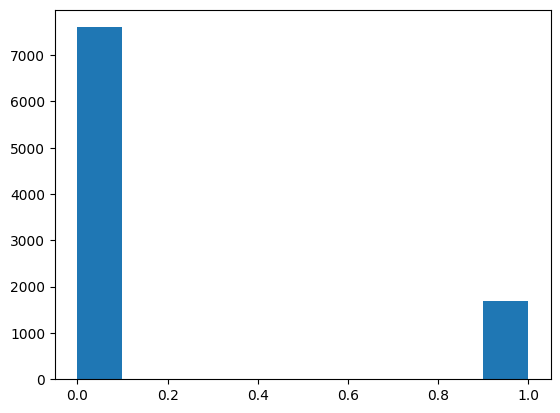

<class 'pandas.core.frame.DataFrame'>
Index: 9280 entries, 5456 to 1463
Data columns (total 84 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Customer_Age                               9280 non-null   int64  
 1   ALERT_Triggered_In_HolidayPeriod           9280 non-null   int64  
 2   Customer_can_Overdraft                     9280 non-null   int64  
 3   Customer_has_Loan                          9280 non-null   int64  
 4   Customer_has_Depot                         9280 non-null   int64  
 5   Customer_has_InstallmentPension            9280 non-null   int64  
 6   Customer_has_SelfPension                   9280 non-null   int64  
 7   Customer_has_BusinessAccount               9280 non-null   int64  
 8   Customer_Gender                            9280 non-null   int64  
 9   Customer_Large_Deposits                    9280 non-null   float64
 10  Customer_Large_Withdrawals

,Customer_Age,ALERT_Triggered_In_HolidayPeriod,Customer_can_Overdraft,Customer_has_Loan,Customer_has_Depot,Customer_has_InstallmentPension,Customer_has_SelfPension,Customer_has_BusinessAccount,Customer_Gender,Customer_Large_Deposits,...,Express_12mo_Debit_SumDKK,Express_12mo_Debit_Count,Express_Ratio_SumDKK,Express_Ratio_Count,Gambling_Debit_SumDKK,Gambling_Debit_Count,Gambling_Debit_AvgDKK,Gambling_Credit_SumDKK,Gambling_Credit_Count,Gambling_Credit_AvgDKK
count,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,...,9.280000e+03,9280.000000,9280.000000,9280.000000,9.280000e+03,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000
mean,47.695690,0.137716,0.282974,0.039009,0.022306,0.202263,0.009483,0.009806,0.694397,0.080388,...,1.077188e+05,8.999246,0.038682,0.346363,1.025026e+04,12.949461,192.708657,1155.279741,0.244612,264.822708
std,16.106167,0.344620,0.450468,0.193626,0.147685,0.401709,0.096922,0.098544,0.460687,0.271907,...,6.472871e+05,37.406565,0.089599,0.688157,8.496806e+04,65.138861,876.372003,13686.449191,2.557597,3153.397416
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,59.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,2.071925e+04,2.000000,0.024710,0.309188,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
max,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.845004e+07,582.000000,0.692741,4.402383,2.266373e+06,1030.000000,25200.000000,390100.000000,125.000000,91875.000000


In [3]:
print(X_train.shape)
plt.hist(y_train)
plt.show()
print(X_train.info())
X_train.describe()

## 1.2 Modeling

In [4]:
param_grid = {
    'max_depth': [5, 6, 7],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.8, 0.9],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200, 400, 500]
}

param_grid = {
    'max_depth': [5],
    'min_child_weight': [1],
    'gamma': [0.3],
    'subsample': [0.9],
    'colsample_bytree': [0.9],
    'learning_rate': [0.2],
    'n_estimators': [100]
}

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', seed=42)

# Custom scorer for AUPRC
auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Setting up GridSearchCV with the AUPRC scorer
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring=auprc_scorer, n_jobs=-1, cv=3, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[CV 1/3] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9;, score=0.769 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9;, score=0.768 total time=   0.3s
[CV 3/3] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9;, score=0.731 total time=   0.3s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=No...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.9], 'gamma': [0.3],
                         'learning_rate': [0.2], 'max_depth': [5],
                         'min_child_weight': [1], 'n_estimators': [100],
                         'subsample': [0.9]},
             scoring=make_scorer(average_precision_score, response_method='predict_proba'),
             verbose=3)

## 1.3 Results (without Threshold)

In [5]:
# Best found model in the Grid Search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best parameters found: ", best_params)

# Predictions on training set
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Predictions on testing set
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Evaluation metrics - Training
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_pr_auc = auc(recall_train, precision_train)

# Evaluation metrics - Testing
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

Best parameters found:  {'colsample_bytree': 0.9, 'gamma': 0.3, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


In [6]:
# Displaying results
print("Training ROC-AUC: {:.4f}".format(train_roc_auc))
print("Training AU-PRC: {:.4f}".format(train_pr_auc))
print("Testing ROC-AUC: {:.4f}".format(roc_auc))
print("Testing AU-PRC: {:.4f}".format(pr_auc))

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, y_train_pred))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_pred))

Training ROC-AUC: 0.9891
Training AU-PRC: 0.9681
Testing ROC-AUC: 0.9221
Testing AU-PRC: 0.7977

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7600
           1       0.98      0.81      0.89      1680

    accuracy                           0.96      9280
   macro avg       0.97      0.90      0.93      9280
weighted avg       0.96      0.96      0.96      9280


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1900
           1       0.83      0.61      0.70       420

    accuracy                           0.91      2320
   macro avg       0.87      0.79      0.82      2320
weighted avg       0.90      0.91      0.90      2320



## 1.4 Results with Threshold (Test Values only)

In [7]:
# calculate the F1 score for each threshold
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

# get the index of the threshold for the highest F1 score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

# get the best precision, recall, and F1 score
best_precision = precision[best_threshold_idx]
best_recall = recall[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print("Best Threshold: {:.4f}".format(best_threshold))
print("Best Precision: {:.4f}".format(best_precision))
print("Best Recall: {:.4f}".format(best_recall))
print("Best F1 Score: {:.4f}".format(best_f1))

Best Threshold: 0.3502
Best Precision: 0.7621
Best Recall: 0.7095
Best F1 Score: 0.7349


In [8]:
best_threshold = 0.2
# Predictions on training set
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
train_predictions = (y_train_pred_proba >= best_threshold).astype(int)

# Predictions on testing set
probabilities = best_model.predict_proba(X_test)[:, 1]
predictions = (probabilities >= best_threshold).astype(int)

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, train_predictions))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, predictions))


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      7600
           1       0.78      0.95      0.86      1680

    accuracy                           0.94      9280
   macro avg       0.89      0.95      0.91      9280
weighted avg       0.95      0.94      0.95      9280


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      1900
           1       0.63      0.80      0.71       420

    accuracy                           0.88      2320
   macro avg       0.79      0.85      0.81      2320
weighted avg       0.89      0.88      0.88      2320



## 1.5 Plot ROC and PR Curves

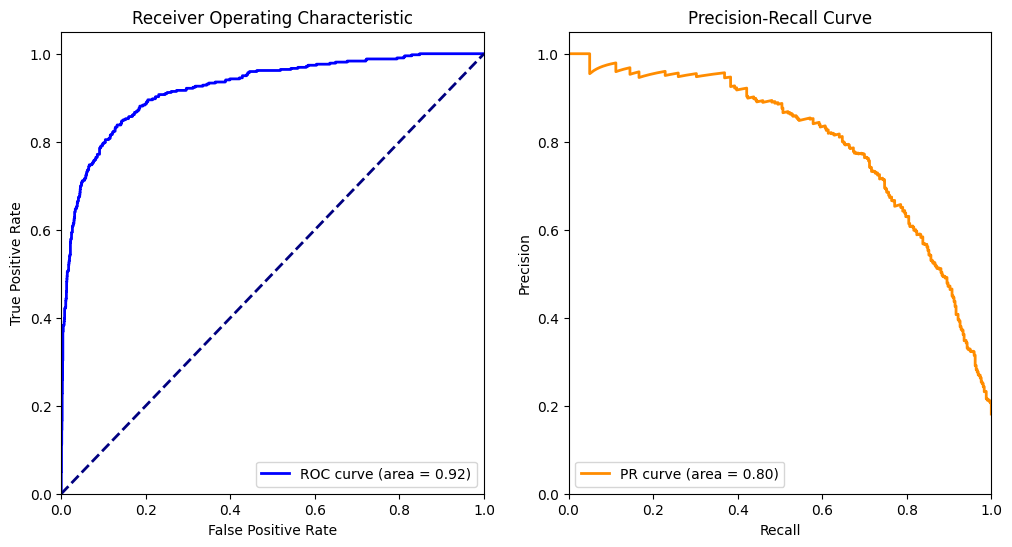

In [9]:
plt.figure(figsize=(12, 6))

# ROC Curve on the left
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# PR Curve on the right
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()

## 1.6 Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

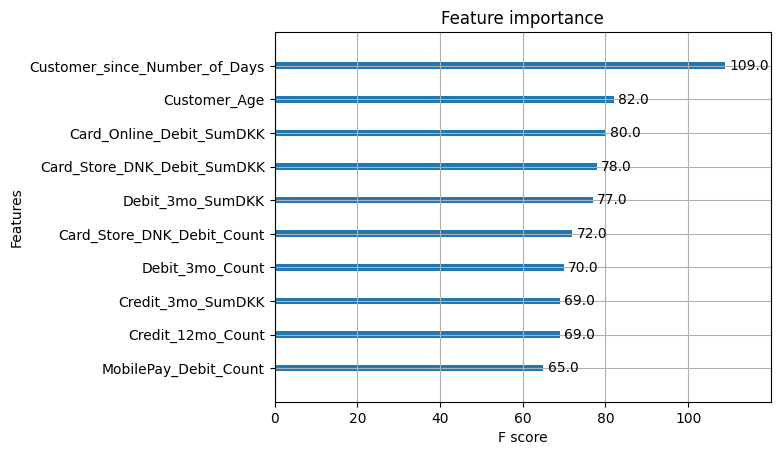

In [10]:
# change the figure size for this plot
xgb.plot_importance(best_model, max_num_features=10)

In [11]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

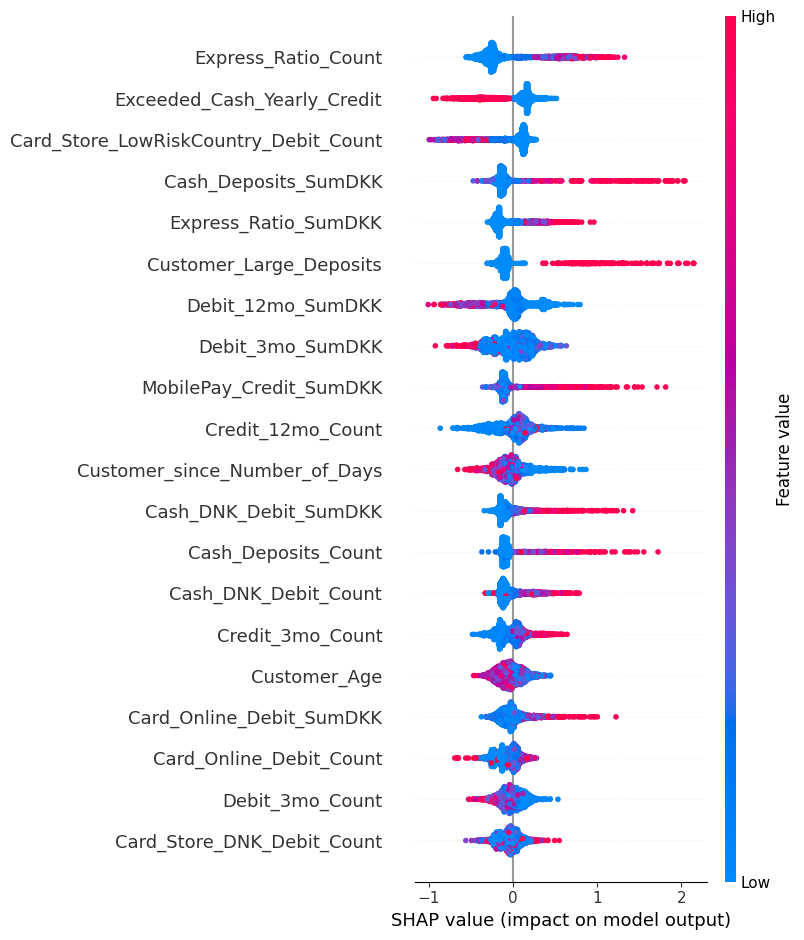

In [12]:
shap.summary_plot(shap_values, X_test)

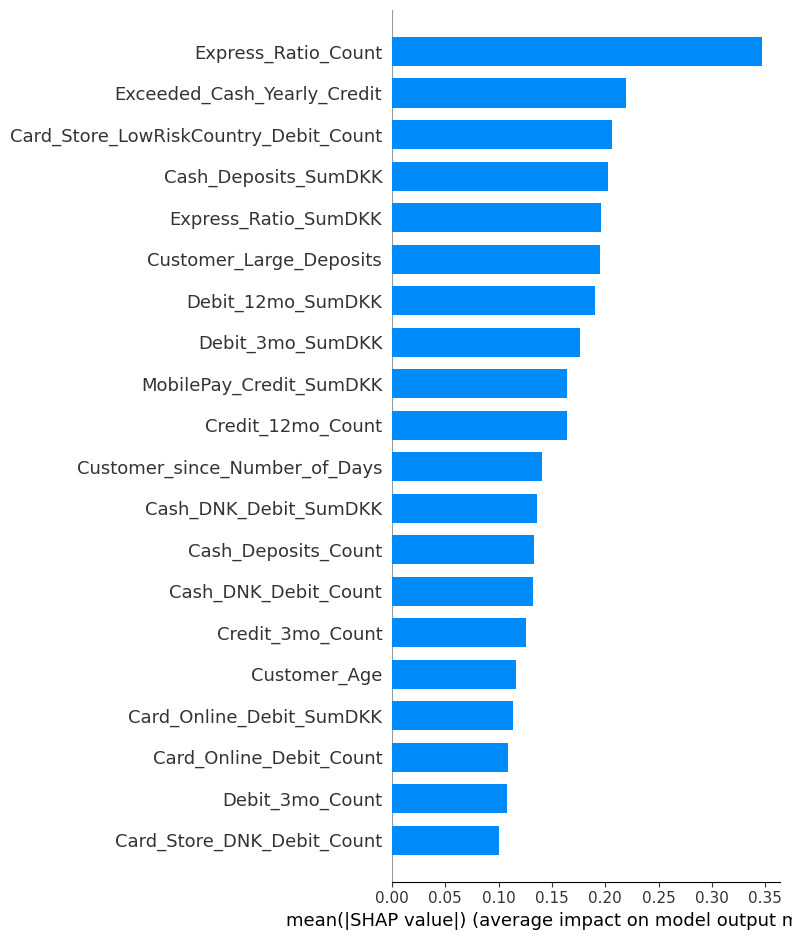

In [13]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 2. XGBoost w/ SMOTE

## 2.1 Import Data (No PCA + SMOTE)

In [14]:
X_train, X_test, y_train, y_test = Preprocessing.load_data(pca_bool=False, smote_bool=True)

/Users/finnfeddersen/Documents/FraudDetection/Preprocessing.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CASE_STATUS_CODE'] = df['CASE_STATUS_CODE'].replace({'C': 0, 'R': 1})


Checking the output of the preprocessing

(15200, 84)


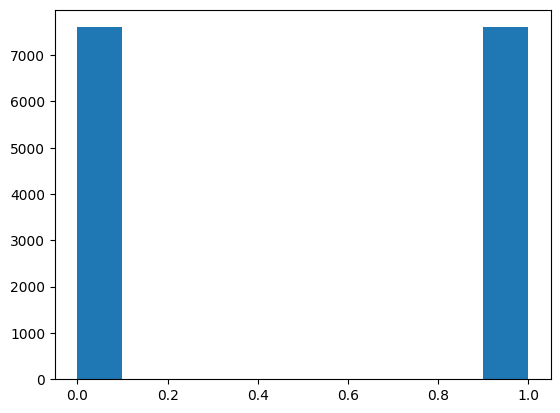

,Customer_Age,ALERT_Triggered_In_HolidayPeriod,Customer_can_Overdraft,Customer_has_Loan,Customer_has_Depot,Customer_has_InstallmentPension,Customer_has_SelfPension,Customer_has_BusinessAccount,Customer_Gender,Customer_Large_Deposits,...,Gambling_Debit_SumDKK,Gambling_Debit_Count,Gambling_Debit_AvgDKK,Gambling_Credit_SumDKK,Gambling_Credit_Count,Gambling_Credit_AvgDKK,RiskGroup_1.0,RiskGroup_2.0,RiskGroup_3.0,RiskGroup_4.0
count,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,...,1.520000e+04,15200.000000,15200.000000,15200.000000,1.520000e+04,15200.000000,15200.000000,15200.000000,1.520000e+04,1.520000e+04
mean,45.161655,0.125212,0.226763,0.035969,0.015643,0.158620,0.007312,0.006039,0.724748,0.147534,...,1.550024e+04,19.600275,292.586234,1416.302429,3.026541e-01,337.744300,0.385377,0.335122,1.231498e-01,1.563513e-01
std,15.815061,0.320665,0.409568,0.184087,0.123581,0.358785,0.084925,0.077408,0.435427,0.349960,...,1.008828e+05,84.562550,1072.324575,14497.251815,2.689006e+00,3373.369281,0.479724,0.462644,3.212114e-01,3.568160e-01
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,-2.775558e-17,0.000000,0.000000,0.000000,1.387779e-17,-1.387779e-17
25%,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073580,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,-2.775558e-17,0.000000,0.000000,0.000000,1.387779e-17,-1.387779e-17
50%,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,-2.775558e-17,0.000000,0.000000,0.000000,1.387779e-17,-1.387779e-17
75%,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,5.335116e+02,2.000000,129.954665,0.000000,-2.775558e-17,0.000000,1.000000,1.000000,1.387779e-17,-1.387779e-17
max,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.266373e+06,1030.000000,25200.000000,390100.000000,1.250000e+02,91875.000000,1.000000,1.000000,1.000000e+00,1.000000e+00


In [15]:
print(X_train.shape)
plt.hist(y_train)
plt.show()
X_train.describe()

## 2.2 Modeling

In [16]:
param_grid = {
    'max_depth': [5, 6, 7],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.8, 0.9],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200, 400, 500]
}

param_grid = {
    'max_depth': [5],
    'min_child_weight': [1],
    'gamma': [0.3],
    'subsample': [0.9],
    'colsample_bytree': [0.9],
    'learning_rate': [0.2],
    'n_estimators': [100]
}

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', seed=42)

# Custom scorer for AUPRC
auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Setting up GridSearchCV with the AUPRC scorer
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring=auprc_scorer, n_jobs=-1, cv=3, verbose=3)
grid_search.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9;, score=0.987 total time=   0.4s
[CV 1/3] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9;, score=0.945 total time=   0.4s
[CV 2/3] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9;, score=0.991 total time=   0.4s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=No...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.9], 'gamma': [0.3],
                         'learning_rate': [0.2], 'max_depth': [5],
                         'min_child_weight': [1], 'n_estimators': [100],
                         'subsample': [0.9]},
             scoring=make_scorer(average_precision_score, response_method='predict_proba'),
             verbose=3)

## 2.3 Results (without Threshold)

In [17]:
# Best found model in the Grid Search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best parameters found: ", best_params)

# Predictions on training set
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Predictions on testing set
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Evaluation metrics - Training
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_pr_auc = auc(recall_train, precision_train)

# Evaluation metrics - Testing
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

Best parameters found:  {'colsample_bytree': 0.9, 'gamma': 0.3, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}


In [18]:
# Displaying results
print("Training ROC-AUC: {:.4f}".format(train_roc_auc))
print("Training AU-PRC: {:.4f}".format(train_pr_auc))
print("Testing ROC-AUC: {:.4f}".format(roc_auc))
print("Testing AU-PRC: {:.4f}".format(pr_auc))

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, y_train_pred))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_pred))

Training ROC-AUC: 0.9939
Training AU-PRC: 0.9945
Testing ROC-AUC: 0.9151
Testing AU-PRC: 0.7826

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      7600
           1       0.98      0.94      0.96      7600

    accuracy                           0.96     15200
   macro avg       0.96      0.96      0.96     15200
weighted avg       0.96      0.96      0.96     15200


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1900
           1       0.75      0.69      0.72       420

    accuracy                           0.90      2320
   macro avg       0.84      0.82      0.83      2320
weighted avg       0.90      0.90      0.90      2320



## 2.4 Results with Threshold (Test Values only)

In [19]:
# calculate the F1 score for each threshold
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

# get the index of the threshold for the highest F1 score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

# get the best precision, recall, and F1 score
best_precision = precision[best_threshold_idx]
best_recall = recall[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print("Best Threshold: {:.4f}".format(best_threshold))
print("Best Precision: {:.4f}".format(best_precision))
print("Best Recall: {:.4f}".format(best_recall))
print("Best F1 Score: {:.4f}".format(best_f1))

Best Threshold: 0.4114
Best Precision: 0.7011
Best Recall: 0.7595
Best F1 Score: 0.7291


In [20]:
best_threshold = 0.2
# Predictions on training set
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
train_predictions = (y_train_pred_proba >= best_threshold).astype(int)

# Predictions on testing set
probabilities = best_model.predict_proba(X_test)[:, 1]
predictions = (probabilities >= best_threshold).astype(int)

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, train_predictions))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, predictions))


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      7600
           1       0.86      0.99      0.92      7600

    accuracy                           0.92     15200
   macro avg       0.93      0.92      0.92     15200
weighted avg       0.93      0.92      0.92     15200


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.96      0.80      0.88      1900
           1       0.49      0.87      0.63       420

    accuracy                           0.82      2320
   macro avg       0.73      0.84      0.75      2320
weighted avg       0.88      0.82      0.83      2320



## 2.5 Plot ROC and PR Curves

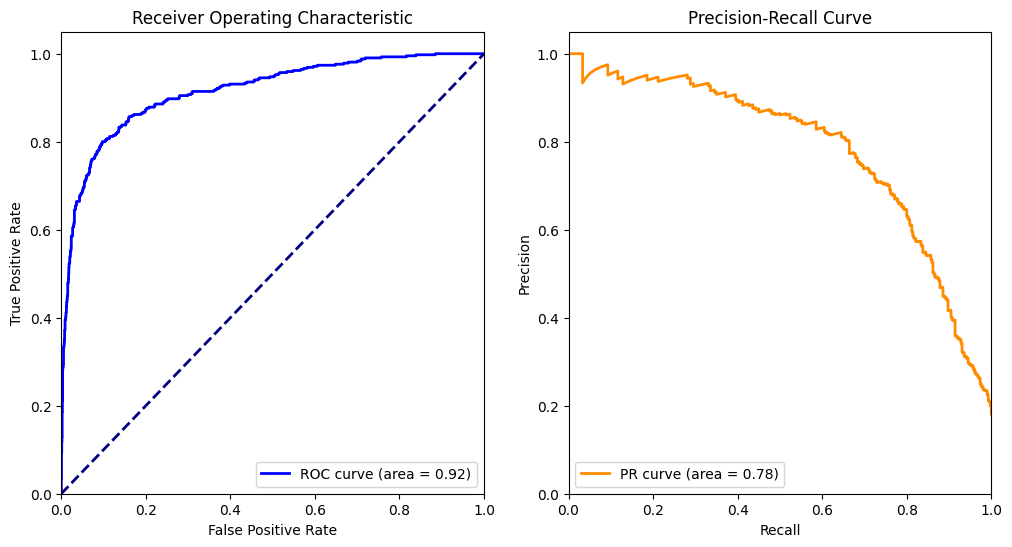

In [21]:
plt.figure(figsize=(12, 6))

# ROC Curve on the left
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# PR Curve on the right
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()

## 2.6 Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

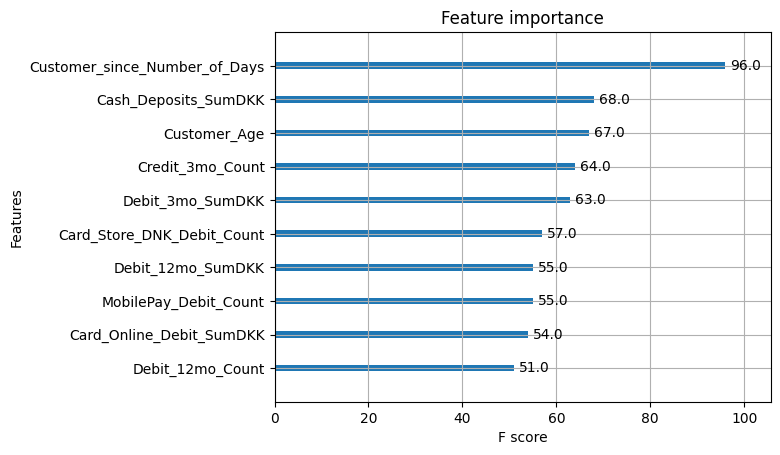

In [22]:
# change the figure size for this plot
xgb.plot_importance(best_model, max_num_features=10)

In [23]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

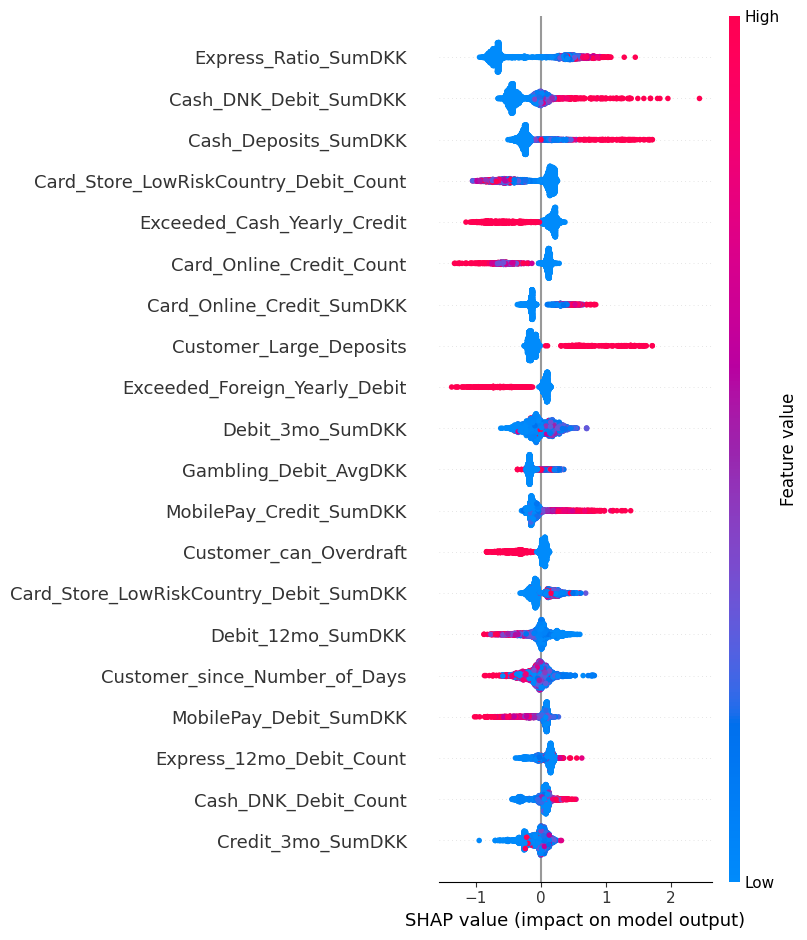

In [24]:
shap.summary_plot(shap_values, X_test)

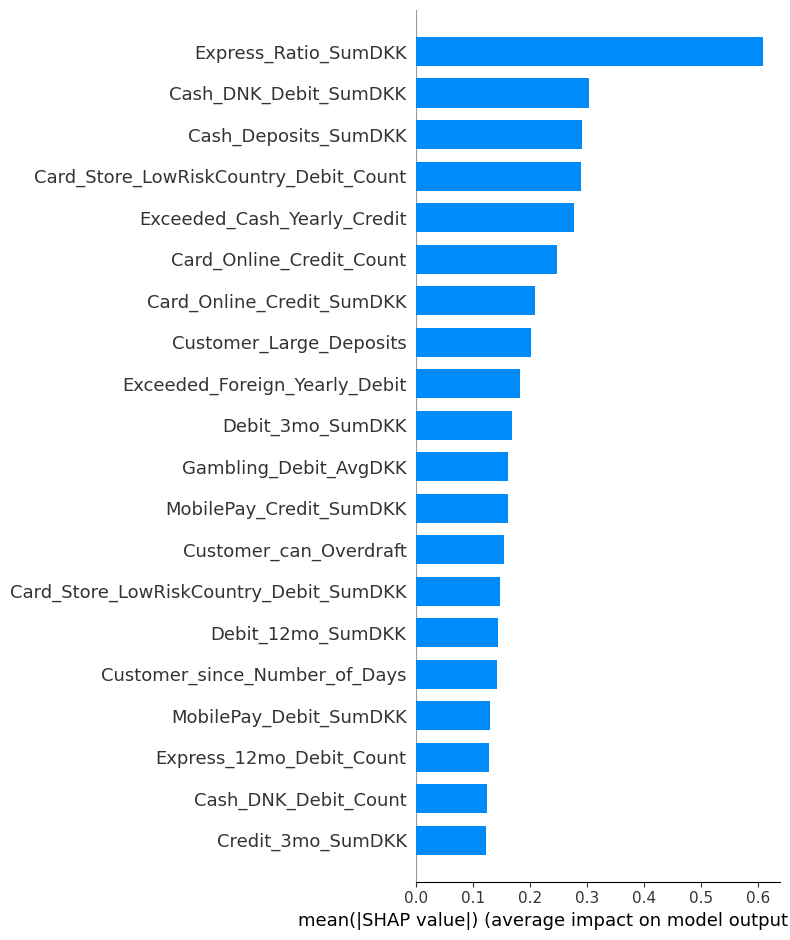

In [25]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 3. Random Forest w/o SMOTE

## 3.1 Import Data (No PCA + No SMOTE)

In [18]:
X_train, X_test, y_train, y_test = Preprocessing.load_data(pca_bool=False, smote_bool=False)

/Users/finnfeddersen/Documents/FraudDetection/Preprocessing.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CASE_STATUS_CODE'] = df['CASE_STATUS_CODE'].replace({'C': 0, 'R': 1})


Checking the output of the preprocessing

(9280, 84)


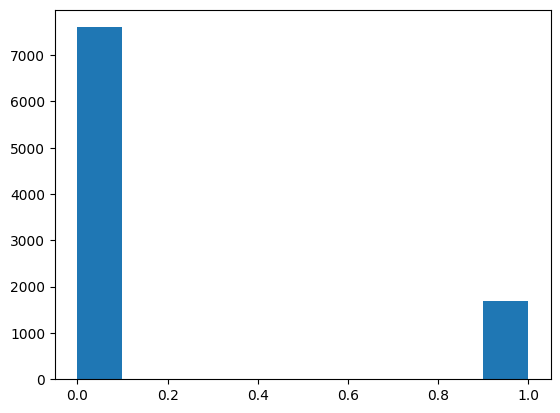

,Customer_Age,ALERT_Triggered_In_HolidayPeriod,Customer_can_Overdraft,Customer_has_Loan,Customer_has_Depot,Customer_has_InstallmentPension,Customer_has_SelfPension,Customer_has_BusinessAccount,Customer_Gender,Customer_Large_Deposits,...,Express_12mo_Debit_SumDKK,Express_12mo_Debit_Count,Express_Ratio_SumDKK,Express_Ratio_Count,Gambling_Debit_SumDKK,Gambling_Debit_Count,Gambling_Debit_AvgDKK,Gambling_Credit_SumDKK,Gambling_Credit_Count,Gambling_Credit_AvgDKK
count,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,...,9.280000e+03,9280.000000,9280.000000,9280.000000,9.280000e+03,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000
mean,47.695690,0.137716,0.282974,0.039009,0.022306,0.202263,0.009483,0.009806,0.694397,0.080388,...,1.077188e+05,8.999246,0.038682,0.346363,1.025026e+04,12.949461,192.708657,1155.279741,0.244612,264.822708
std,16.106167,0.344620,0.450468,0.193626,0.147685,0.401709,0.096922,0.098544,0.460687,0.271907,...,6.472871e+05,37.406565,0.089599,0.688157,8.496806e+04,65.138861,876.372003,13686.449191,2.557597,3153.397416
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,59.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,2.071925e+04,2.000000,0.024710,0.309188,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
max,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.845004e+07,582.000000,0.692741,4.402383,2.266373e+06,1030.000000,25200.000000,390100.000000,125.000000,91875.000000


In [19]:
print(X_train.shape)
plt.hist(y_train)
plt.show()
X_train.describe()

## 3.2 Modeling

In [22]:
# Create a pipeline with SMOTE and RandomForest
param_grid = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'min_samples_split': [2, 5, 10, 20, 50, 100]
}

param_grid = {
    'max_depth': [20],
    'min_samples_leaf': [200],
    'n_estimators': [200],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced'],
    'min_samples_split': [100]
}

rf_clf = RandomForestClassifier(random_state=42)

auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, scoring=auprc_scorer, n_jobs=-1, cv=3, verbose=3)
grid_search.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 2/3] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200;, score=0.530 total time=   0.7s
[CV 1/3] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200;, score=0.517 total time=   0.7s
[CV 3/3] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, n_estimators=200;, score=0.545 total time=   0.9s
[CV 3/3] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200;, score=0.538 total time=   0.6s
[CV 1/3] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, n_estimators=200;, score=0.521 total time=   0.8s
[CV 2/3] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, n_estim

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'max_depth': [20],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [200], 'min_samples_split': [100],
                         'n_estimators': [200]},
             scoring=make_scorer(average_precision_score, response_method='predict_proba'),
             verbose=3)

## 1.3 Results (without Threshold)

In [23]:
# Best found model in the Grid Search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best parameters found: ", best_params)

# Predictions on training set
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Predictions on testing set
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Evaluation metrics - Training
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_pr_auc = auc(recall_train, precision_train)

# Evaluation metrics - Testing
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

Best parameters found:  {'class_weight': 'balanced', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 200, 'min_samples_split': 100, 'n_estimators': 200}


In [24]:
# Displaying results
print("Training ROC-AUC: {:.4f}".format(train_roc_auc))
print("Training AU-PRC: {:.4f}".format(train_pr_auc))
print("Testing ROC-AUC: {:.4f}".format(roc_auc))
print("Testing AU-PRC: {:.4f}".format(pr_auc))

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, y_train_pred))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_pred))

Training ROC-AUC: 0.8610
Training AU-PRC: 0.6071
Testing ROC-AUC: 0.8457
Testing AU-PRC: 0.5784

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      7600
           1       0.42      0.79      0.55      1680

    accuracy                           0.77      9280
   macro avg       0.68      0.77      0.70      9280
weighted avg       0.85      0.77      0.79      9280


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.94      0.75      0.84      1900
           1       0.41      0.79      0.54       420

    accuracy                           0.76      2320
   macro avg       0.68      0.77      0.69      2320
weighted avg       0.85      0.76      0.78      2320



## 1.4 Results with Threshold (Test Values only)

In [29]:
# calculate the F1 score for each threshold
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

# get the index of the threshold for the highest F1 score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

# get the best precision, recall, and F1 score
best_precision = precision[best_threshold_idx]
best_recall = recall[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print("Best Threshold: {:.4f}".format(best_threshold))
print("Best Precision: {:.4f}".format(best_precision))
print("Best Recall: {:.4f}".format(best_recall))
print("Best F1 Score: {:.4f}".format(best_f1))

Best Threshold: 0.6051
Best Precision: 0.4982
Best Recall: 0.6548
Best F1 Score: 0.5658


In [30]:
#best_threshold = 0.4982
# Predictions on training set
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
train_predictions = (y_train_pred_proba >= best_threshold).astype(int)

# Predictions on testing set
probabilities = best_model.predict_proba(X_test)[:, 1]
predictions = (probabilities >= best_threshold).astype(int)

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, train_predictions))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, predictions))


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      7600
           1       0.52      0.68      0.59      1680

    accuracy                           0.83      9280
   macro avg       0.72      0.77      0.74      9280
weighted avg       0.85      0.83      0.84      9280


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1900
           1       0.50      0.65      0.57       420

    accuracy                           0.82      2320
   macro avg       0.71      0.75      0.73      2320
weighted avg       0.84      0.82      0.83      2320



## 1.5 Plot ROC and PR Curves

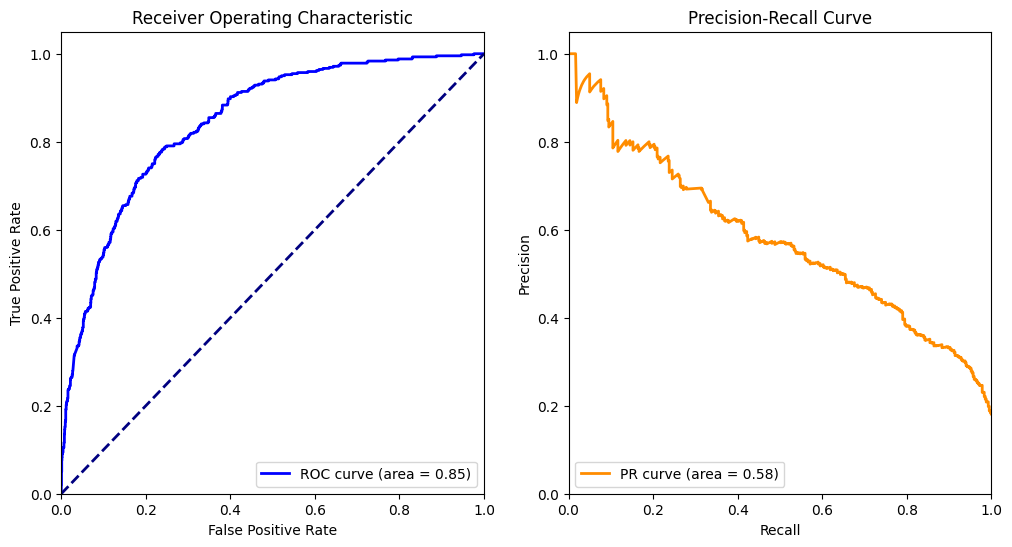

In [31]:
plt.figure(figsize=(12, 6))

# ROC Curve on the left
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# PR Curve on the right
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()

# 4. Random Forest w SMOTE

## 4.1 Import Data (No PCA + SMOTE)

In [26]:
X_train, X_test, y_train, y_test = Preprocessing.load_data(pca_bool=False, smote_bool=True)

/Users/finnfeddersen/Documents/FraudDetection/Preprocessing.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CASE_STATUS_CODE'] = df['CASE_STATUS_CODE'].replace({'C': 0, 'R': 1})


Checking the output of the preprocessing

(15200, 84)


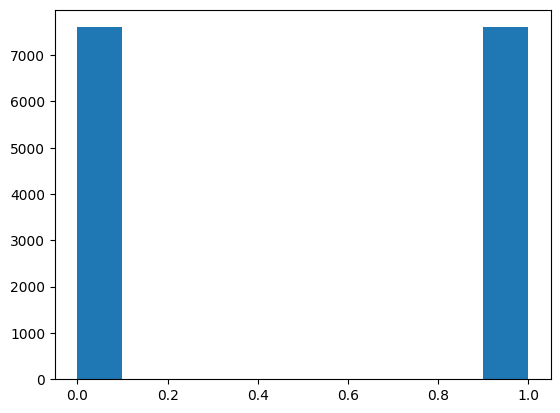

,Customer_Age,ALERT_Triggered_In_HolidayPeriod,Customer_can_Overdraft,Customer_has_Loan,Customer_has_Depot,Customer_has_InstallmentPension,Customer_has_SelfPension,Customer_has_BusinessAccount,Customer_Gender,Customer_Large_Deposits,...,Gambling_Debit_SumDKK,Gambling_Debit_Count,Gambling_Debit_AvgDKK,Gambling_Credit_SumDKK,Gambling_Credit_Count,Gambling_Credit_AvgDKK,RiskGroup_1.0,RiskGroup_2.0,RiskGroup_3.0,RiskGroup_4.0
count,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,15200.000000,...,1.520000e+04,15200.000000,15200.000000,15200.000000,1.520000e+04,15200.000000,15200.000000,15200.000000,1.520000e+04,1.520000e+04
mean,45.161655,0.125212,0.226763,0.035969,0.015643,0.158620,0.007312,0.006039,0.724748,0.147534,...,1.550024e+04,19.600275,292.586234,1416.302429,3.026541e-01,337.744300,0.385377,0.335122,1.231498e-01,1.563513e-01
std,15.815061,0.320665,0.409568,0.184087,0.123581,0.358785,0.084925,0.077408,0.435427,0.349960,...,1.008828e+05,84.562550,1072.324575,14497.251815,2.689006e+00,3373.369281,0.479724,0.462644,3.212114e-01,3.568160e-01
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,-2.775558e-17,0.000000,0.000000,0.000000,1.387779e-17,-1.387779e-17
25%,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073580,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,-2.775558e-17,0.000000,0.000000,0.000000,1.387779e-17,-1.387779e-17
50%,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,-2.775558e-17,0.000000,0.000000,0.000000,1.387779e-17,-1.387779e-17
75%,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,5.335116e+02,2.000000,129.954665,0.000000,-2.775558e-17,0.000000,1.000000,1.000000,1.387779e-17,-1.387779e-17
max,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.266373e+06,1030.000000,25200.000000,390100.000000,1.250000e+02,91875.000000,1.000000,1.000000,1.000000e+00,1.000000e+00


In [27]:
print(X_train.shape)
plt.hist(y_train)
plt.show()
X_train.describe()

## 4.2 Modeling

In [28]:
# Create a pipeline with SMOTE and RandomForest
param_grid = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'min_samples_split': [2, 5, 10, 20, 50, 100]
}

param_grid = {
    'max_depth': [20],
    'min_samples_leaf': [200],
    'n_estimators': [200],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced'],
    'min_samples_split': [100]
}

rf_clf = RandomForestClassifier(random_state=42)

auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, scoring=auprc_scorer, n_jobs=-1, cv=3, verbose=3)
grid_search.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 3/3] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200;, score=0.877 total time=   1.6s
[CV 2/3] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200;, score=0.882 total time=   1.7s
[CV 1/3] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200;, score=0.835 total time=   1.8s
[CV 3/3] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, n_estimators=200;, score=0.880 total time=   2.3s
[CV 2/3] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, n_estimators=200;, score=0.884 total time=   2.1s
[CV 1/3] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, n_estim

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'max_depth': [20],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [200], 'min_samples_split': [100],
                         'n_estimators': [200]},
             scoring=make_scorer(average_precision_score, response_method='predict_proba'),
             verbose=3)

## 4.3 Results (without Threshold)

In [29]:
# Best found model in the Grid Search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best parameters found: ", best_params)

# Predictions on training set
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Predictions on testing set
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Evaluation metrics - Training
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_pr_auc = auc(recall_train, precision_train)

# Evaluation metrics - Testing
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

Best parameters found:  {'class_weight': 'balanced', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 200, 'min_samples_split': 100, 'n_estimators': 200}


In [30]:
# Displaying results
print("Training ROC-AUC: {:.4f}".format(train_roc_auc))
print("Training AU-PRC: {:.4f}".format(train_pr_auc))
print("Testing ROC-AUC: {:.4f}".format(roc_auc))
print("Testing AU-PRC: {:.4f}".format(pr_auc))

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, y_train_pred))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_pred))

Training ROC-AUC: 0.8962
Training AU-PRC: 0.9003
Testing ROC-AUC: 0.8371
Testing AU-PRC: 0.5858

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      7600
           1       0.80      0.80      0.80      7600

    accuracy                           0.80     15200
   macro avg       0.80      0.80      0.80     15200
weighted avg       0.80      0.80      0.80     15200


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1900
           1       0.44      0.71      0.55       420

    accuracy                           0.78      2320
   macro avg       0.68      0.76      0.70      2320
weighted avg       0.84      0.78      0.80      2320



## 4.4 Results with Threshold (Test Values only)

In [31]:
# calculate the F1 score for each threshold
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

# get the index of the threshold for the highest F1 score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

# get the best precision, recall, and F1 score
best_precision = precision[best_threshold_idx]
best_recall = recall[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print("Best Threshold: {:.4f}".format(best_threshold))
print("Best Precision: {:.4f}".format(best_precision))
print("Best Recall: {:.4f}".format(best_recall))
print("Best F1 Score: {:.4f}".format(best_f1))

Best Threshold: 0.5571
Best Precision: 0.4734
Best Recall: 0.6786
Best F1 Score: 0.5577


In [32]:
#best_threshold = 0.4982
# Predictions on training set
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
train_predictions = (y_train_pred_proba >= best_threshold).astype(int)

# Predictions on testing set
probabilities = best_model.predict_proba(X_test)[:, 1]
predictions = (probabilities >= best_threshold).astype(int)

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, train_predictions))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, predictions))


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      7600
           1       0.82      0.78      0.80      7600

    accuracy                           0.81     15200
   macro avg       0.81      0.81      0.81     15200
weighted avg       0.81      0.81      0.81     15200


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.92      0.83      0.88      1900
           1       0.47      0.68      0.56       420

    accuracy                           0.81      2320
   macro avg       0.70      0.76      0.72      2320
weighted avg       0.84      0.81      0.82      2320



## 4.5 Plot ROC and PR Curves

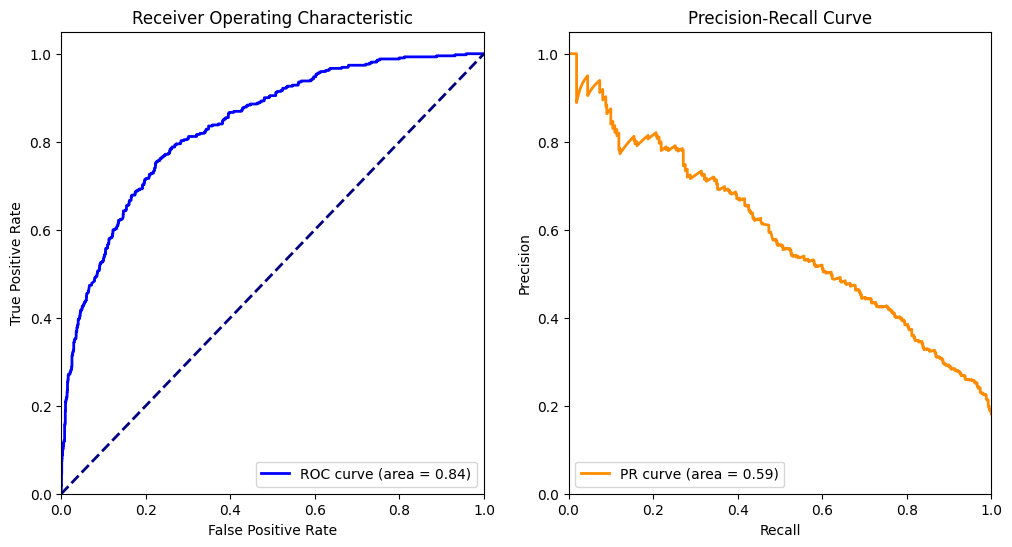

In [33]:
plt.figure(figsize=(12, 6))

# ROC Curve on the left
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# PR Curve on the right
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()

# 5. Imbalanced Learn Random Forest w/o SMOTE

## 5.1 Import Data (No PCA + NO SMOTE)

In [38]:
X_train, X_test, y_train, y_test = Preprocessing.load_data(pca_bool=False, smote_bool=False)

/Users/finnfeddersen/Documents/FraudDetection/Preprocessing.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CASE_STATUS_CODE'] = df['CASE_STATUS_CODE'].replace({'C': 0, 'R': 1})


Checking the output of the preprocessing

(9280, 84)


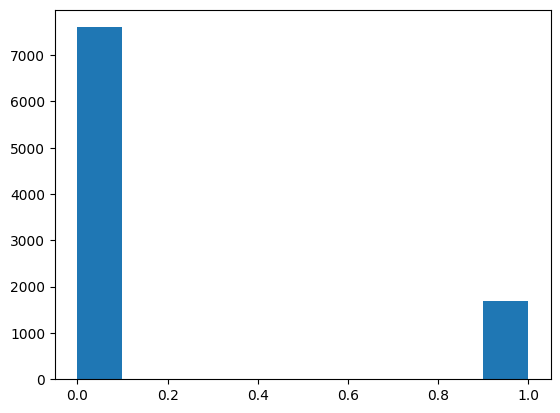

,Customer_Age,ALERT_Triggered_In_HolidayPeriod,Customer_can_Overdraft,Customer_has_Loan,Customer_has_Depot,Customer_has_InstallmentPension,Customer_has_SelfPension,Customer_has_BusinessAccount,Customer_Gender,Customer_Large_Deposits,...,Express_12mo_Debit_SumDKK,Express_12mo_Debit_Count,Express_Ratio_SumDKK,Express_Ratio_Count,Gambling_Debit_SumDKK,Gambling_Debit_Count,Gambling_Debit_AvgDKK,Gambling_Credit_SumDKK,Gambling_Credit_Count,Gambling_Credit_AvgDKK
count,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000,...,9.280000e+03,9280.000000,9280.000000,9280.000000,9.280000e+03,9280.000000,9280.000000,9280.000000,9280.000000,9280.000000
mean,47.695690,0.137716,0.282974,0.039009,0.022306,0.202263,0.009483,0.009806,0.694397,0.080388,...,1.077188e+05,8.999246,0.038682,0.346363,1.025026e+04,12.949461,192.708657,1155.279741,0.244612,264.822708
std,16.106167,0.344620,0.450468,0.193626,0.147685,0.401709,0.096922,0.098544,0.460687,0.271907,...,6.472871e+05,37.406565,0.089599,0.688157,8.496806e+04,65.138861,876.372003,13686.449191,2.557597,3153.397416
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,59.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,2.071925e+04,2.000000,0.024710,0.309188,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
max,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.845004e+07,582.000000,0.692741,4.402383,2.266373e+06,1030.000000,25200.000000,390100.000000,125.000000,91875.000000


In [39]:
print(X_train.shape)
plt.hist(y_train)
plt.show()
X_train.describe()

## 5.2 Modeling

In [40]:
# Create a pipeline with SMOTE and RandomForest
param_grid = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'class_weight': [{0: 1, 1: v} for v in [1, 2, 3, 4, 5, 10, 20]],
    'replacement': [True, False],
    'bootstrap': [True, False]
}

param_grid = {
    'max_depth': [20],
    'min_samples_leaf': [200],
    'n_estimators': [200],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced'],
    'min_samples_split': [100],
    'replacement': [True, False],
    'bootstrap': [True, False]
}

brf = BalancedRandomForestClassifier(random_state=42)  # Explicitly set changing parameters

auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

grid_search = GridSearchCV(estimator=brf, param_grid=param_grid, scoring=auprc_scorer, n_jobs=-1, cv=3, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/homebrew

[CV 3/3] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=True;, score=0.488 total time=   0.6s
[CV 1/3] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=False;, score=0.465 total time=   0.7s
[CV 1/3] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=True;, score=0.469 total time=   0.7s
[CV 2/3] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=True;, score=0.483 total time=   0.7s
[CV 1/3] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=True;, score=0.466 total time=   0.7s
[CV 3/3] 

/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  w

[CV 3/3] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=False;, score=0.485 total time=   0.4s
[CV 2/3] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=False;, score=0.486 total time=   0.6s


/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(


[CV 1/3] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=True;, score=0.489 total time=   0.8s
[CV 2/3] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=True;, score=0.516 total time=   0.8s


/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(


[CV 3/3] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=True;, score=0.519 total time=   0.7s
[CV 1/3] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=False;, score=0.492 total time=   0.7s


/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(


[CV 2/3] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=False;, score=0.512 total time=   0.7s
[CV 3/3] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=False;, score=0.512 total time=   0.7s


/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(


[CV 1/3] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=True;, score=0.486 total time=   0.7s
[CV 1/3] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=True;, score=0.473 total time=   1.9s
[CV 2/3] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=False;, score=0.478 total time=   1.9s
[CV 1/3] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=False;, score=0.474 total time=   1.9s
[CV 3/3] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=True;, score=0.506 total time=   1.9s


/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  w

[CV 2/3] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=True;, score=0.475 total time=   2.1s
[CV 3/3] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=False;, score=0.507 total time=   2.0s
[CV 2/3] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=True;, score=0.507 total time=   0.8s


/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  w

[CV 1/3] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=False;, score=0.488 total time=   0.7s
[CV 3/3] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=True;, score=0.511 total time=   0.8s
[CV 2/3] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=False;, score=0.508 total time=   0.7s
[CV 3/3] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=False;, score=0.511 total time=   0.6s
[CV 3/3] END bootstrap=False, class_weight=balanced, max_depth=20, max_features=None, min_samples_leaf=200, min_samples_split=100, n_estimators=200, replacement=True;, score=0.544 total time=   2.7s
[C

/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(


GridSearchCV(cv=3, estimator=BalancedRandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced'], 'max_depth': [20],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [200], 'min_samples_split': [100],
                         'n_estimators': [200], 'replacement': [True, False]},
             scoring=make_scorer(average_precision_score, response_method='predict_proba'),
             verbose=3)

## 5.3 Results (without Threshold)

In [41]:
# Best found model in the Grid Search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best parameters found: ", best_params)

# Predictions on training set
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Predictions on testing set
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Evaluation metrics - Training
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_pr_auc = auc(recall_train, precision_train)

# Evaluation metrics - Testing
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

Best parameters found:  {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 200, 'min_samples_split': 100, 'n_estimators': 200, 'replacement': True}


In [42]:
# Displaying results
print("Training ROC-AUC: {:.4f}".format(train_roc_auc))
print("Training AU-PRC: {:.4f}".format(train_pr_auc))
print("Testing ROC-AUC: {:.4f}".format(roc_auc))
print("Testing AU-PRC: {:.4f}".format(pr_auc))

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, y_train_pred))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_pred))

Training ROC-AUC: 0.8393
Training AU-PRC: 0.5835
Testing ROC-AUC: 0.8294
Testing AU-PRC: 0.5624

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.98      0.30      0.46      7600
           1       0.24      0.97      0.38      1680

    accuracy                           0.42      9280
   macro avg       0.61      0.64      0.42      9280
weighted avg       0.84      0.42      0.45      9280


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.98      0.30      0.46      1900
           1       0.23      0.98      0.38       420

    accuracy                           0.42      2320
   macro avg       0.61      0.64      0.42      2320
weighted avg       0.85      0.42      0.44      2320



## 5.4 Results with Threshold (Test Values only)

In [43]:
# calculate the F1 score for each threshold
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

# get the index of the threshold for the highest F1 score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

# get the best precision, recall, and F1 score
best_precision = precision[best_threshold_idx]
best_recall = recall[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print("Best Threshold: {:.4f}".format(best_threshold))
print("Best Precision: {:.4f}".format(best_precision))
print("Best Recall: {:.4f}".format(best_recall))
print("Best F1 Score: {:.4f}".format(best_f1))

Best Threshold: 0.8701
Best Precision: 0.4972
Best Recall: 0.6452
Best F1 Score: 0.5617


In [44]:
#best_threshold = 0.4982
# Predictions on training set
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
train_predictions = (y_train_pred_proba >= best_threshold).astype(int)

# Predictions on testing set
probabilities = best_model.predict_proba(X_test)[:, 1]
predictions = (probabilities >= best_threshold).astype(int)

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, train_predictions))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, predictions))


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      7600
           1       0.50      0.63      0.56      1680

    accuracy                           0.82      9280
   macro avg       0.71      0.75      0.72      9280
weighted avg       0.84      0.82      0.83      9280


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.92      0.86      0.88      1900
           1       0.50      0.65      0.56       420

    accuracy                           0.82      2320
   macro avg       0.71      0.75      0.72      2320
weighted avg       0.84      0.82      0.83      2320



## 5.5 Plot ROC and PR Curves

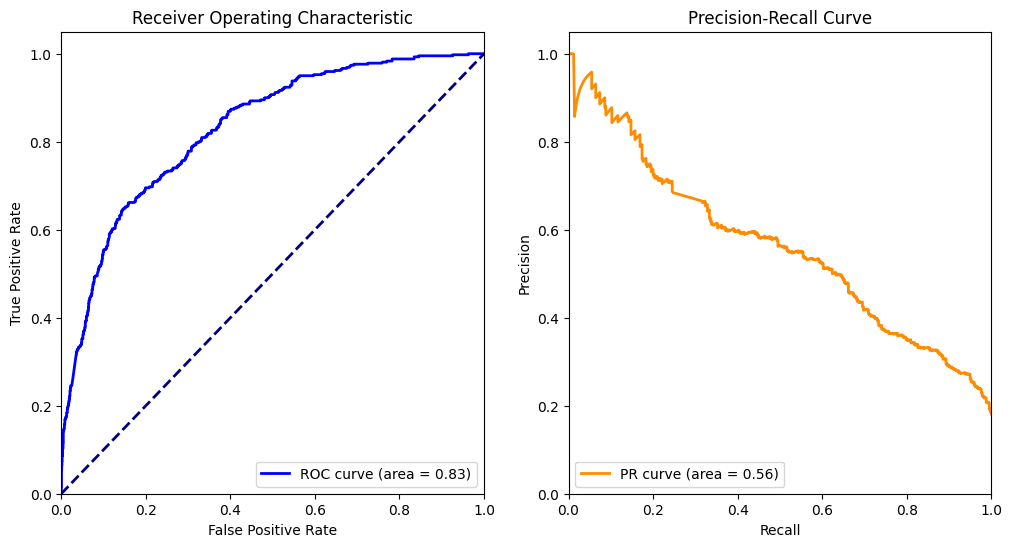

In [45]:
plt.figure(figsize=(12, 6))

# ROC Curve on the left
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# PR Curve on the right
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()

# 6. Logistic Regression w/o SMOTE

## 6.1 Import Data (No PCA + NO SMOTE)

In [56]:
X_train, X_test, y_train, y_test = Preprocessing.load_data(pca_bool=True, smote_bool=False)

/Users/finnfeddersen/Documents/FraudDetection/Preprocessing.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CASE_STATUS_CODE'] = df['CASE_STATUS_CODE'].replace({'C': 0, 'R': 1})


Checking the output of the preprocessing

(9280, 54)


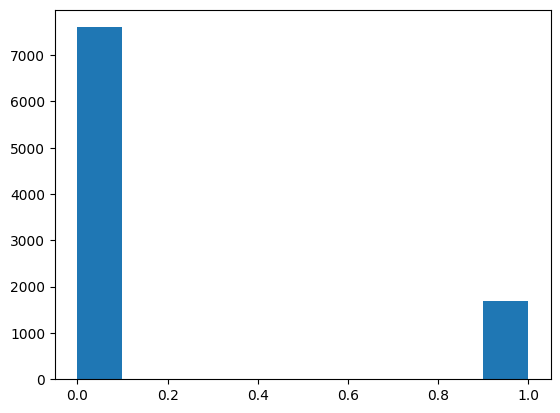

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,9.280000e+03,9.280000e+03,9.280000e+03,9.280000e+03,9.280000e+03,9.280000e+03,9.280000e+03,9.280000e+03,9.280000e+03,9.280000e+03,...,9.280000e+03,9.280000e+03,9.280000e+03,9.280000e+03,9.280000e+03,9.280000e+03,9.280000e+03,9.280000e+03,9.280000e+03,9.280000e+03
mean,1.646193e-16,-3.120110e-17,2.526714e-17,4.517459e-17,1.914178e-17,-1.186790e-16,-8.230964e-17,-2.450147e-17,7.656711e-17,-1.799327e-17,...,-4.211191e-17,3.502945e-17,5.665966e-17,1.703618e-17,-2.411864e-17,-1.703618e-17,-8.460665e-17,1.148507e-18,-9.953724e-18,-1.244215e-18
std,3.016768e+00,2.302953e+00,2.073647e+00,1.884808e+00,1.852588e+00,1.741494e+00,1.662284e+00,1.561068e+00,1.466311e+00,1.441769e+00,...,7.669380e-01,7.462501e-01,7.105971e-01,7.005726e-01,6.956417e-01,6.725382e-01,6.664701e-01,6.395845e-01,6.170627e-01,5.982912e-01
min,-3.593653e+00,-1.065423e+01,-1.051552e+01,-1.526308e+01,-2.397631e+01,-1.255478e+01,-1.636213e+01,-7.100041e+00,-1.193322e+01,-9.424911e+00,...,-7.489487e+00,-4.990016e+00,-4.267263e+00,-6.714911e+00,-2.994284e+00,-5.236202e+00,-5.495114e+00,-6.551492e+00,-7.534174e+00,-7.069536e+00
25%,-2.223036e+00,-9.940001e-01,-5.122243e-01,-8.166590e-01,-4.809734e-01,-5.848400e-01,-5.481677e-01,-8.709335e-01,-8.779034e-01,-3.794566e-01,...,-2.733552e-01,-4.603970e-01,-2.586430e-01,-3.074042e-01,-3.941906e-01,-2.980018e-01,-3.495698e-01,-2.610139e-01,-1.861712e-01,-2.225028e-01
50%,-6.222000e-01,-3.390474e-01,-7.489899e-02,-3.173358e-02,-8.748269e-02,6.308877e-02,9.975284e-02,8.347848e-02,-1.956116e-01,4.777462e-02,...,-8.665553e-04,2.952720e-03,-1.434163e-04,2.818420e-03,-2.018799e-02,-5.342074e-02,-1.212199e-02,-1.780985e-02,7.243758e-03,-4.430079e-02
75%,1.151602e+00,5.880162e-01,4.500421e-01,5.032854e-01,5.452101e-01,5.335514e-01,6.129531e-01,8.842385e-01,7.374136e-01,4.367889e-01,...,2.050842e-01,4.420036e-01,2.749037e-01,2.931494e-01,3.609272e-01,2.448415e-01,3.237381e-01,2.297518e-01,2.123836e-01,2.034571e-01
max,2.426028e+01,2.443589e+01,6.472982e+01,2.596443e+01,2.825930e+01,3.146905e+01,1.740259e+01,1.460406e+01,1.288792e+01,2.808433e+01,...,1.435437e+01,1.189654e+01,1.012510e+01,1.164168e+01,5.211545e+00,6.466126e+00,8.138363e+00,1.095752e+01,1.050270e+01,7.532498e+00


In [57]:
print(X_train.shape)
plt.hist(y_train)
plt.show()
X_train.describe()

## 6.2 Modeling

In [68]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization type
    'class_weight': [None, 'balanced'],  # Option to handle class imbalance
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithms to use in the optimization problem
    'max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}

param_grid = {
    'C': [1],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'class_weight': ['balanced'],  # Option to handle class imbalance
    'solver': ['newton-cg'],  # Algorithms to use in the optimization problem
    'max_iter': [300]  # Maximum number of iterations taken for the solvers to converge
}

# Create the LogisticRegression object
log_reg = LogisticRegression(random_state=42)

# Define the scorer
auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring=auprc_scorer, n_jobs=-1, cv=3, verbose=3)
grid_search.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
3 fits failed out of a total of 6.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_para

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END C=1, class_weight=balanced, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=1, class_weight=balanced, max_iter=300, penalty=l2, solver=newton-cg;, score=0.836 total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=300, penalty=l2, solver=newton-cg;, score=0.843 total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, max_iter=300, penalty=l2, solver=newton-cg;, score=0.829 total time=   0.0s


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [1], 'class_weight': ['balanced'],
                         'max_iter': [300], 'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg']},
             scoring=make_scorer(average_precision_score, response_method='predict_proba'),
             verbose=3)

## 6.3 Results (without Threshold)

In [69]:
# Best found model in the Grid Search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best parameters found: ", best_params)

# Predictions on training set
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Predictions on testing set
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Evaluation metrics - Training
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_pr_auc = auc(recall_train, precision_train)

# Evaluation metrics - Testing
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

Best parameters found:  {'C': 1, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l2', 'solver': 'newton-cg'}


In [70]:
# Displaying results
print("Training ROC-AUC: {:.4f}".format(train_roc_auc))
print("Training AU-PRC: {:.4f}".format(train_pr_auc))
print("Testing ROC-AUC: {:.4f}".format(roc_auc))
print("Testing AU-PRC: {:.4f}".format(pr_auc))

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, y_train_pred))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_pred))

Training ROC-AUC: 0.8522
Training AU-PRC: 0.8394
Testing ROC-AUC: 0.8362
Testing AU-PRC: 0.5380

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      7600
           1       0.80      0.73      0.77      7600

    accuracy                           0.78     15200
   macro avg       0.78      0.78      0.78     15200
weighted avg       0.78      0.78      0.78     15200


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1900
           1       0.45      0.68      0.54       420

    accuracy                           0.79      2320
   macro avg       0.68      0.75      0.70      2320
weighted avg       0.83      0.79      0.80      2320



## 6.4 Results with Threshold (Test Values only)

In [71]:
# calculate the F1 score for each threshold
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

# get the index of the threshold for the highest F1 score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

# get the best precision, recall, and F1 score
best_precision = precision[best_threshold_idx]
best_recall = recall[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print("Best Threshold: {:.4f}".format(best_threshold))
print("Best Precision: {:.4f}".format(best_precision))
print("Best Recall: {:.4f}".format(best_recall))
print("Best F1 Score: {:.4f}".format(best_f1))

Best Threshold: 0.5523
Best Precision: 0.4887
Best Recall: 0.6667
Best F1 Score: 0.5639


In [72]:
#best_threshold = 0.4982
# Predictions on training set
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
train_predictions = (y_train_pred_proba >= best_threshold).astype(int)

# Predictions on testing set
probabilities = best_model.predict_proba(X_test)[:, 1]
predictions = (probabilities >= best_threshold).astype(int)

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, train_predictions))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, predictions))


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.73      0.85      0.79      7600
           1       0.82      0.69      0.75      7600

    accuracy                           0.77     15200
   macro avg       0.78      0.77      0.77     15200
weighted avg       0.78      0.77      0.77     15200


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1900
           1       0.49      0.67      0.56       420

    accuracy                           0.81      2320
   macro avg       0.70      0.76      0.72      2320
weighted avg       0.84      0.81      0.82      2320



## 6.5 Plot ROC and PR Curves

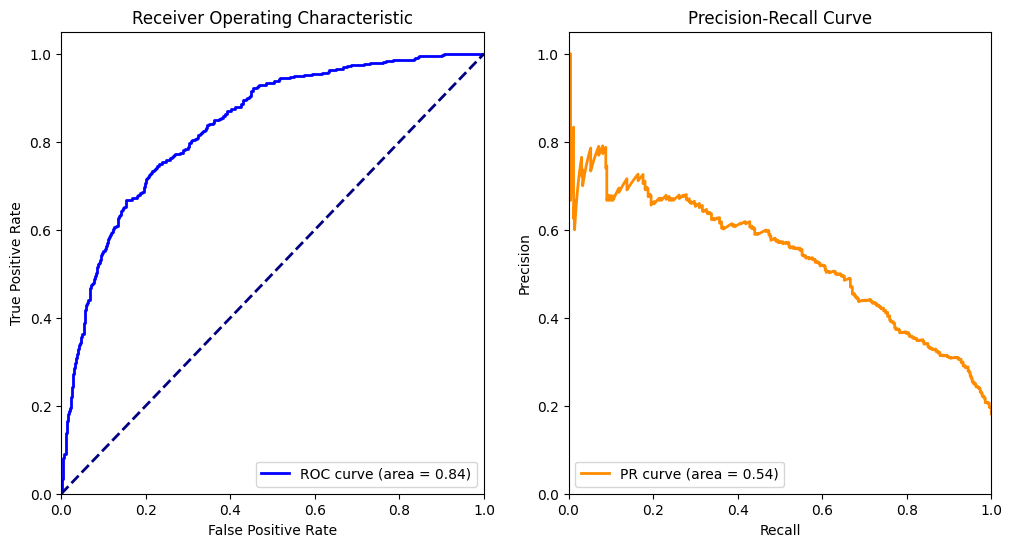

In [73]:
plt.figure(figsize=(12, 6))

# ROC Curve on the left
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# PR Curve on the right
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()

# 7. Logistic Regression w SMOTE

## 7.1 Import Data (No PCA + SMOTE)

In [74]:
X_train, X_test, y_train, y_test = Preprocessing.load_data(pca_bool=True, smote_bool=True)

/Users/finnfeddersen/Documents/FraudDetection/Preprocessing.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CASE_STATUS_CODE'] = df['CASE_STATUS_CODE'].replace({'C': 0, 'R': 1})


Checking the output of the preprocessing

(15200, 53)


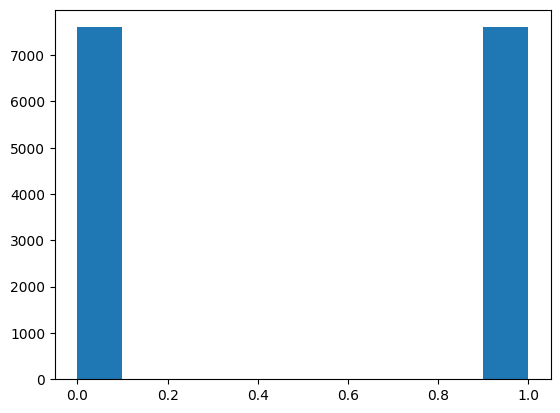

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
count,1.520000e+04,1.520000e+04,1.520000e+04,1.520000e+04,1.520000e+04,1.520000e+04,1.520000e+04,1.520000e+04,1.520000e+04,1.520000e+04,...,1.520000e+04,1.520000e+04,1.520000e+04,1.520000e+04,1.520000e+04,1.520000e+04,1.520000e+04,1.520000e+04,1.520000e+04,1.520000e+04
mean,-2.333572e-15,-3.649946e-15,-2.842171e-16,-2.991759e-15,-5.609548e-15,-8.234816e-15,1.352649e-14,1.029165e-14,-6.731457e-17,-8.147868e-16,...,-6.329440e-16,4.307198e-15,-6.277552e-15,8.717237e-15,1.191094e-14,4.700801e-15,1.767008e-15,-1.863492e-14,4.440892e-15,4.123018e-16
std,3.111025e+00,2.266452e+00,2.097816e+00,1.947940e+00,1.850528e+00,1.771178e+00,1.720063e+00,1.627722e+00,1.484176e+00,1.454750e+00,...,7.572679e-01,7.242479e-01,6.940733e-01,6.854484e-01,6.744549e-01,6.599232e-01,6.408622e-01,6.224367e-01,5.951811e-01,5.883221e-01
min,-4.005270e+00,-1.013274e+01,-1.117908e+01,-1.905895e+01,-1.562382e+01,-1.086396e+01,-1.576561e+01,-7.208669e+00,-7.726426e+00,-8.504188e+00,...,-7.613770e+00,-3.010572e+00,-2.636620e+00,-6.429448e+00,-5.109828e+00,-4.642972e+00,-4.421393e+00,-3.615282e+00,-7.987191e+00,-5.069194e+00
25%,-2.123039e+00,-1.094991e+00,-5.828944e-01,-8.469508e-01,-4.425944e-01,-6.763334e-01,-7.076351e-01,-9.209405e-01,-8.539325e-01,-3.543309e-01,...,-3.202787e-01,-4.603461e-01,-2.354878e-01,-3.403450e-01,-3.010648e-01,-3.672840e-01,-3.489623e-01,-2.885482e-01,-2.516107e-01,-2.612038e-01
50%,-6.554700e-01,-3.723054e-01,-9.706347e-02,3.963187e-02,2.614484e-03,-1.378092e-01,1.088580e-01,-9.014857e-03,-2.061615e-01,-1.443410e-02,...,1.258114e-02,-6.762784e-03,6.902507e-03,-2.848906e-02,2.388017e-02,1.903356e-02,-4.882928e-03,-3.612730e-02,5.686894e-03,1.048925e-02
75%,1.284119e+00,8.525836e-01,4.257415e-01,6.874635e-01,4.795055e-01,3.486556e-01,7.411514e-01,8.228597e-01,7.350604e-01,4.052541e-01,...,3.965186e-01,4.500763e-01,2.097006e-01,2.809561e-01,2.788784e-01,3.783082e-01,3.488955e-01,2.272484e-01,2.703920e-01,2.365554e-01
max,2.046190e+01,2.533027e+01,7.614533e+01,1.907232e+01,5.556402e+01,3.170533e+01,2.534329e+01,1.809848e+01,1.287132e+01,3.289352e+01,...,3.447734e+01,1.366945e+01,1.374113e+01,9.248437e+00,1.127021e+01,8.505281e+00,7.527601e+00,4.483833e+00,1.184847e+01,1.070203e+01


In [75]:
print(X_train.shape)
plt.hist(y_train)
plt.show()
X_train.describe()

## 7.2 Modeling

In [76]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization type
    'class_weight': [None, 'balanced'],  # Option to handle class imbalance
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithms to use in the optimization problem
    'max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}

param_grid = {
    'C': [1],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'class_weight': ['balanced'],  # Option to handle class imbalance
    'solver': ['newton-cg'],  # Algorithms to use in the optimization problem
    'max_iter': [300]  # Maximum number of iterations taken for the solvers to converge
}

# Create the LogisticRegression object
log_reg = LogisticRegression(random_state=42)

# Define the scorer
auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring=auprc_scorer, n_jobs=-1, cv=3, verbose=3)
grid_search.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
3 fits failed out of a total of 6.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_para

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END C=1, class_weight=balanced, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, max_iter=300, penalty=l2, solver=newton-cg;, score=0.829 total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, max_iter=300, penalty=l2, solver=newton-cg;, score=0.843 total time=   0.0s
[CV 1/3] END C=1, class_weight=balanced, max_iter=300, penalty=l2, solver=newton-cg;, score=0.836 total time=   0.0s


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [1], 'class_weight': ['balanced'],
                         'max_iter': [300], 'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg']},
             scoring=make_scorer(average_precision_score, response_method='predict_proba'),
             verbose=3)

## 7.3 Results (without Threshold)

In [77]:
# Best found model in the Grid Search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best parameters found: ", best_params)

# Predictions on training set
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Predictions on testing set
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Evaluation metrics - Training
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_pr_auc = auc(recall_train, precision_train)

# Evaluation metrics - Testing
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

Best parameters found:  {'C': 1, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l2', 'solver': 'newton-cg'}


In [78]:
# Displaying results
print("Training ROC-AUC: {:.4f}".format(train_roc_auc))
print("Training AU-PRC: {:.4f}".format(train_pr_auc))
print("Testing ROC-AUC: {:.4f}".format(roc_auc))
print("Testing AU-PRC: {:.4f}".format(pr_auc))

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, y_train_pred))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_pred))

Training ROC-AUC: 0.8522
Training AU-PRC: 0.8394
Testing ROC-AUC: 0.8362
Testing AU-PRC: 0.5380

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      7600
           1       0.80      0.73      0.77      7600

    accuracy                           0.78     15200
   macro avg       0.78      0.78      0.78     15200
weighted avg       0.78      0.78      0.78     15200


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1900
           1       0.45      0.68      0.54       420

    accuracy                           0.79      2320
   macro avg       0.68      0.75      0.70      2320
weighted avg       0.83      0.79      0.80      2320



## 7.4 Results with Threshold (Test Values only)

In [79]:
# calculate the F1 score for each threshold
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

# get the index of the threshold for the highest F1 score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

# get the best precision, recall, and F1 score
best_precision = precision[best_threshold_idx]
best_recall = recall[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print("Best Threshold: {:.4f}".format(best_threshold))
print("Best Precision: {:.4f}".format(best_precision))
print("Best Recall: {:.4f}".format(best_recall))
print("Best F1 Score: {:.4f}".format(best_f1))

Best Threshold: 0.5523
Best Precision: 0.4887
Best Recall: 0.6667
Best F1 Score: 0.5639


In [80]:
#best_threshold = 0.4982
# Predictions on training set
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
train_predictions = (y_train_pred_proba >= best_threshold).astype(int)

# Predictions on testing set
probabilities = best_model.predict_proba(X_test)[:, 1]
predictions = (probabilities >= best_threshold).astype(int)

# Classification report
print("\nClassification Report for Training Data:")
print(classification_report(y_train, train_predictions))
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, predictions))


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.73      0.85      0.79      7600
           1       0.82      0.69      0.75      7600

    accuracy                           0.77     15200
   macro avg       0.78      0.77      0.77     15200
weighted avg       0.78      0.77      0.77     15200


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1900
           1       0.49      0.67      0.56       420

    accuracy                           0.81      2320
   macro avg       0.70      0.76      0.72      2320
weighted avg       0.84      0.81      0.82      2320



## 7.5 Plot ROC and PR Curves

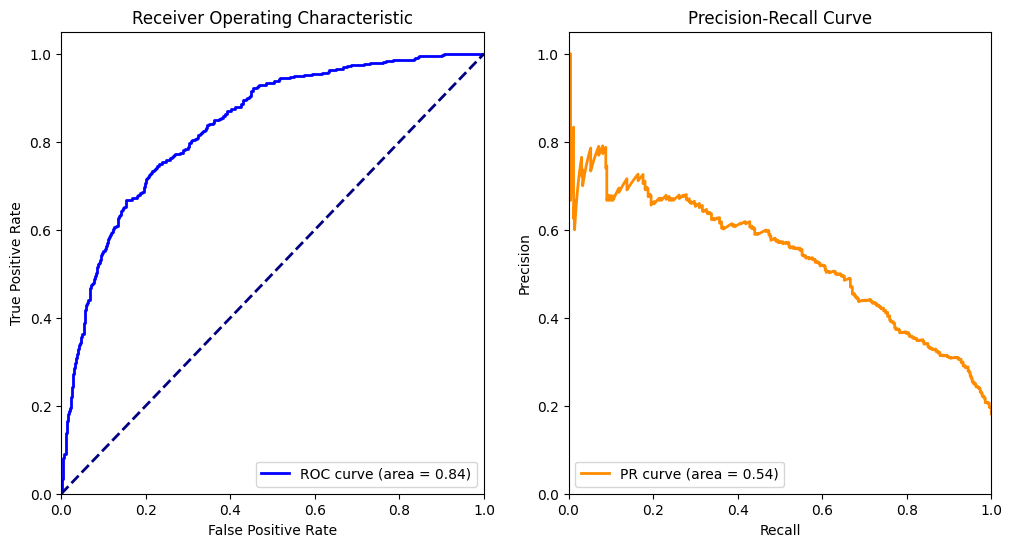

In [81]:
plt.figure(figsize=(12, 6))

# ROC Curve on the left
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# PR Curve on the right
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()